# Работа с пропущенными значениями в данных

В этом ноутбуке разберём практические подходы к работе с пропущенными значениями в табличных данных.

План:

- откуда берутся пропуски (интуитивно про MCAR / MAR / MNAR);
- как обнаруживать и визуализировать пропуски;
- простые стратегии: удаление строк / столбцов, заполнение mean / median / constant;
- использование `SimpleImputer` и пайплайнов `sklearn`;
- **признаки-индикаторы пропусков** (missingness indicator features);
- `KNNImputer` как пример более сложного подхода;
- пример с категориальными признаками;
- краткие практические рекомендации.

Мы будем работать на синтетическом примере классификации (breast_cancer из `sklearn`), куда сами добавим пропуски, а также на маленьком искусственном примере с категориальными признаками.

## 1. Импорт библиотек и загрузка данных

Начнём с импорта необходимых библиотек и загрузки базового датасета без пропусков.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['figure.dpi'] = 120

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1.1. Базовый датасет без пропусков

Возьмём классический датасет `breast_cancer` из `sklearn`. В нём все признаки числовые, и изначально нет `NaN`.

In [2]:
data = load_breast_cancer()
X_full = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

X_full.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

## 2. Теоретически: откуда берутся пропуски

В реальных данных пропуски (`NaN`) появляются по разным причинам:

- пользователь не заполнил поле в форме;
- технический сбой при сборе данных;
- данные потерялись при интеграции / миграции;
- значение не определено для части объектов (например, поле про "количество детей" для бездетных).

На уровне интуиции выделяют три типа пропусков:

1. **MCAR (Missing Completely At Random)** — значения отсутствуют полностью случайно,    не зависят ни от наблюдаемых, ни от скрытых признаков.
2. **MAR (Missing At Random)** — вероятность пропуска зависит только от **наблюдаемых** признаков    (например, молодые чаще не указывают доход, но возраст нам известен).
3. **MNAR (Missing Not At Random)** — вероятность пропуска зависит от **самого отсутствующего значения**    (например, люди с очень высоким доходом чаще не хотят его указывать).

В реальных проектах редко удаётся точно определить тип пропусков, но важно помнить: выбор стратегии обработки пропусков — это не только техника, но и гипотеза о природе данных.

## 3. Искусственно добавляем пропуски

Чтобы продемонстрировать различные подходы, искусственно добавим пропуски в несколько числовых признаков.

Сделаем примерно $10\%$ пропусков в трёх колонках.

In [4]:
X = X_full.copy()

n_samples, n_features = X.shape
print('Число объектов:', n_samples)
print('Число признаков:', n_features)

# Выберем несколько признаков, куда будем добавлять пропуски
cols_with_missing = [data.feature_names[0], data.feature_names[5], data.feature_names[10]]
cols_with_missing

Число объектов: 569
Число признаков: 30


[np.str_('mean radius'), np.str_('mean compactness'), np.str_('radius error')]

In [5]:
missing_fraction = 0.1  # 10% пропусков в выбранных колонках

for col in cols_with_missing:
    n_missing = int(missing_fraction * n_samples)
    missing_indices = np.random.choice(n_samples, size=n_missing, replace=False)
    X.loc[missing_indices, col] = np.nan

# Проверим количество пропусков в выбранных колонках
X[cols_with_missing].isna().sum()

mean radius         56
mean compactness    56
radius error        56
dtype: int64

## 4. Обнаружение и визуализация пропусков

Посмотрим, как распределены пропуски по признакам и строкам.

In [6]:
missing_per_column = X.isna().sum().sort_values(ascending=False)
missing_per_column.head(10)

mean radius            56
mean compactness       56
radius error           56
mean texture            0
mean area               0
mean perimeter          0
mean smoothness         0
mean concavity          0
mean symmetry           0
mean concave points     0
dtype: int64

In [7]:
(missing_per_column / len(X)).head(10)

mean radius            0.098418
mean compactness       0.098418
radius error           0.098418
mean texture           0.000000
mean area              0.000000
mean perimeter         0.000000
mean smoothness        0.000000
mean concavity         0.000000
mean symmetry          0.000000
mean concave points    0.000000
dtype: float64

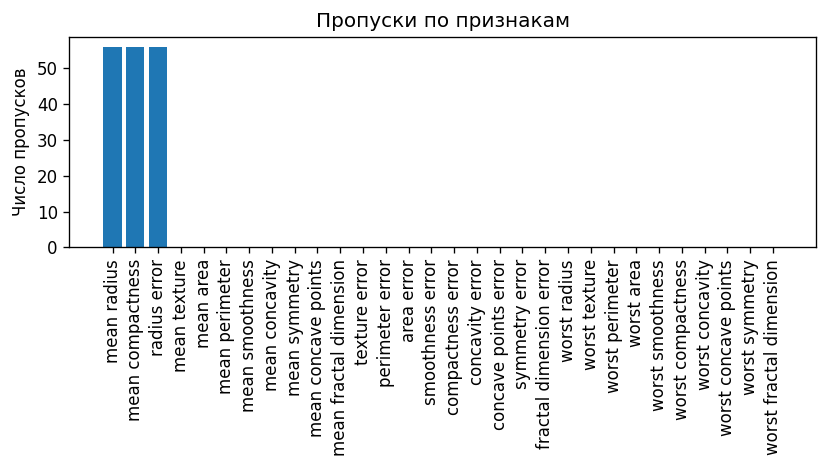

In [8]:
# Гистограмма числа пропусков по признакам
plt.figure()
plt.bar(range(len(missing_per_column)), missing_per_column.values)
plt.xticks(range(len(missing_per_column)), missing_per_column.index, rotation=90)
plt.ylabel('Число пропусков')
plt.title('Пропуски по признакам')
plt.tight_layout()
plt.show()

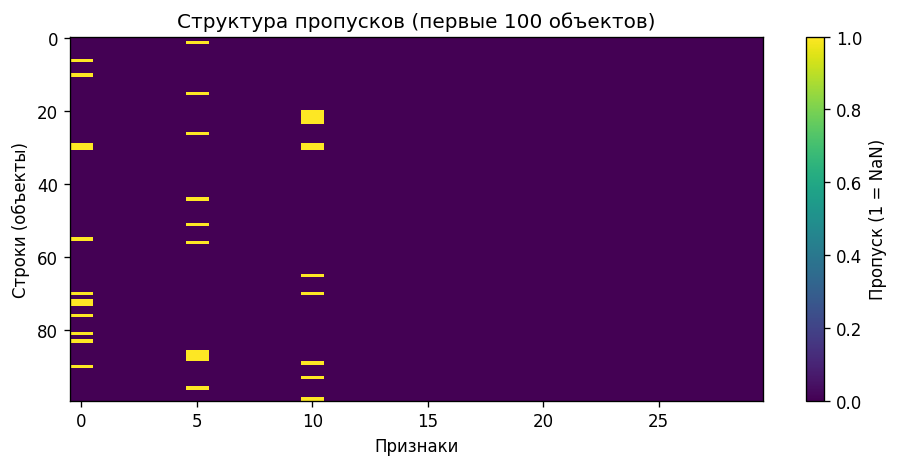

In [9]:
# Тепловая карта пропусков для первых 100 объектов
sample_size = 100
mask = X.iloc[:sample_size].isna().values

plt.figure(figsize=(8, 4))
plt.imshow(mask, aspect='auto', interpolation='nearest')
plt.colorbar(label='Пропуск (1 = NaN)')
plt.xlabel('Признаки')
plt.ylabel('Строки (объекты)')
plt.title('Структура пропусков (первые 100 объектов)')
plt.tight_layout()
plt.show()

## 5. Простые стратегии: удаление строк и столбцов

### 5.1. Удаление строк с пропусками

Простейший вариант — удалить все строки, где есть хотя бы один `NaN`.

Проблемы:

- при заметной доле пропусков мы сильно уменьшаем выборку;
- если пропуски не MCAR, выборка становится смещённой.

In [10]:
X_drop_rows = X.dropna(axis=0)
y_drop_rows = y.loc[X_drop_rows.index]

print('Размер исходных данных:', X.shape)
print('Размер после dropna по строкам:', X_drop_rows.shape)

Размер исходных данных: (569, 30)
Размер после dropna по строкам: (418, 30)


### 5.2. Удаление столбцов с большой долей пропусков

Иногда один-два признака содержат почти одни пропуски — их проще удалить целиком. Например, можно удалить признаки с долей пропусков $>30\%$.

In [11]:
threshold = 0.3
high_missing_cols = missing_per_column[missing_per_column / len(X) > threshold].index.tolist()

print('Признаки с >30% пропусков:', high_missing_cols)
X_drop_cols = X.drop(columns=high_missing_cols)
print('Размер после удаления таких признаков:', X_drop_cols.shape)

Признаки с >30% пропусков: []
Размер после удаления таких признаков: (569, 30)


## 6. Правильный порядок: train/test split до заполнения пропусков

Очень важный момент: сначала делаем **train/test split**, а уже потом оцениваем параметры заполнения пропусков только на train.

Если мы считаем среднее / медиану по всему набору (train+test), то информация из теста подтекает в обучение, и качество на тесте получается завышенным.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape

((455, 30), (114, 30))

### 6.1. Бейзлайн: логистическая регрессия на строках без пропусков

Для ориентира посмотрим на качество, если просто отбросить строки с пропусками и обучиться на "чистой" подвыборке.

In [13]:
train_mask_no_na = ~X_train.isna().any(axis=1)
test_mask_no_na = ~X_test.isna().any(axis=1)

X_train_no_na = X_train[train_mask_no_na]
y_train_no_na = y_train[train_mask_no_na]

X_test_no_na = X_test[test_mask_no_na]
y_test_no_na = y_test[test_mask_no_na]

print('Размер train без пропусков:', X_train_no_na.shape)
print('Размер test без пропусков:', X_test_no_na.shape)

Размер train без пропусков: (341, 30)
Размер test без пропусков: (77, 30)


In [14]:
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

baseline_pipeline.fit(X_train_no_na, y_train_no_na)
y_pred_baseline = baseline_pipeline.predict(X_test_no_na)

print('Accuracy (baseline, только строки без NaN):', accuracy_score(y_test_no_na, y_pred_baseline))
print()
print(classification_report(y_test_no_na, y_pred_baseline))

Accuracy (baseline, только строки без NaN): 0.974025974025974

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.96      0.98        50

    accuracy                           0.97        77
   macro avg       0.97      0.98      0.97        77
weighted avg       0.98      0.97      0.97        77



## 7. Заполнение числовых пропусков: `SimpleImputer`

Более реалистичный подход — **заполнять** пропуски, не выбрасывая строки. Для числовых признаков типичные стратегии:

- среднее значение по столбцу (`strategy='mean'`);
- медиана (`strategy='median'`);
- константа (`strategy='constant'`, например $0$ или $-1$).

Реализуем это через пайплайн `sklearn`.

In [15]:
def build_numeric_impute_pipeline(strategy):
    return Pipeline([
        ('imputer', SimpleImputer(strategy=strategy)),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ])

strategies = ['mean', 'median', 'constant']

for strat in strategies:
    pipe = build_numeric_impute_pipeline(strategy=strat)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Strategy = {strat:8s} | Accuracy = {acc:.3f}")

Strategy = mean     | Accuracy = 0.982
Strategy = median   | Accuracy = 0.982
Strategy = constant | Accuracy = 0.974


Посмотрим подробно на одну из стратегий (например, `median`).

In [16]:
best_strategy = 'median'
pipe_median = build_numeric_impute_pipeline(strategy=best_strategy)
pipe_median.fit(X_train, y_train)
y_pred_median = pipe_median.predict(X_test)

print('Стратегия:', best_strategy)
print('Accuracy:', accuracy_score(y_test, y_pred_median))
print()
print(classification_report(y_test, y_pred_median))

Стратегия: median
Accuracy: 0.9824561403508771

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## 8. Признаки-индикаторы пропусков (missingness indicators)

Иногда сам факт того, что значение **отсутствует**, является сильным сигналом. Примеры:

- клиент с очень высоким доходом не заполняет поле `income`;
- пользователь с проблемной историей кредитов не заполняет поле о предыдущих кредитах.

В таких случаях полезно добавить отдельные бинарные признаки, которые показывают, что значение было пропущено:

- исходный признак: `feature`;
- новый признак: `feature_was_missing` (0 или 1).

В `sklearn` это можно делать:

- вручную (создавая столбцы-индикаторы);
- или с помощью `SimpleImputer(add_indicator=True)` — он автоматически добавит индикаторы для столбцов, в которых были пропуски.

Сравним две модели:

1. Логистическая регрессия с заполнением медианой (без индикаторов);
2. Та же логистика, но с `add_indicator=True`.

In [17]:
from sklearn.impute import MissingIndicator

# Вариант 1: как раньше (медиана, без индикаторов)
pipe_no_indicator = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
])

# Вариант 2: тот же imputer, но с индикаторами пропусков
pipe_with_indicator = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
])

for name, pipe in [('No indicator', pipe_no_indicator), ('With indicator', pipe_with_indicator)]:
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:15s} | Accuracy = {acc:.3f}")

No indicator    | Accuracy = 0.982
With indicator  | Accuracy = 0.982


Эффект от индикаторов зависит от датасета: иногда качество почти не меняется, иногда — заметно растёт, если "пропущено" действительно несёт информацию.

## 9. Более продвинутый метод: `KNNImputer`

`KNNImputer` заполняет пропуски, используя ближайших соседей:

- для объекта с пропуском ищем $k$ ближайших соседей по остальным признакам;
- берём среднее значение по соседям (по каждому признаку с пропуском).

Это может лучше учитывать структуру данных, но:

- работает медленнее;
- чувствителен к масштабированию и размерности признаков.

In [18]:
knn_impute_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
])

knn_impute_pipeline.fit(X_train, y_train)
y_pred_knn_imp = knn_impute_pipeline.predict(X_test)

print('Accuracy (KNNImputer):', accuracy_score(y_test, y_pred_knn_imp))
print()
print(classification_report(y_test, y_pred_knn_imp))

Accuracy (KNNImputer): 0.9824561403508771

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## 10. Пример с категориальными признаками

До сих пор мы работали только с числовыми признаками. В реальных данных часто есть категориальные признаки (`city`, `gender`, `device_type` и т.п.), в которых тоже бывают пропуски.

Типичные стратегии:

- заполнить модой (`strategy='most_frequent'`);
- заполнить специальной категорией (например, `'missing'`) через `strategy='constant'`;
- для моделей, которые умеют работать с категориями (например, `CatBoost`), можно оставить `NaN` и передавать индексы категориальных признаков.

Сделаем маленький игрушечный пример.

In [19]:
df_cat = pd.DataFrame({
    'age': [25, 30, np.nan, 40, 35, np.nan, 50, 45],
    'city': ['Moscow', 'SPb', 'SPb', np.nan, 'Moscow', 'Kazan', 'Kazan', np.nan],
    'target': [0, 1, 1, 0, 0, 1, 0, 1],
})

df_cat

,age,city,target
0,25.0,Moscow,0
1,30.0,SPb,1
2,NaN,SPb,1
3,40.0,NaN,0
4,35.0,Moscow,0
5,NaN,Kazan,1
6,50.0,Kazan,0
7,45.0,NaN,1


Разделим признаки на числовые и категориальные и построим пайплайн с предобработкой и логистической регрессией.

In [20]:
X_cat = df_cat[['age', 'city']]
y_cat = df_cat['target']

numeric_features = ['age']
categorical_features = ['city']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

clf_cat = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
])

clf_cat.fit(X_cat, y_cat)
y_cat_pred = clf_cat.predict(X_cat)

print('Accuracy на игрушечных данных (категориальные + числовые):', accuracy_score(y_cat, y_cat_pred))

Accuracy на игрушечных данных (категориальные + числовые): 0.875


Здесь можно обсудить:

- смысл отдельной категории `'missing'` — пропуск как сигнал;
- почему `handle_unknown='ignore'` важен для новых категорий на тесте;
- что для бустеров (например, `CatBoost`) обработка категориальных признаков и `NaN` делается иначе.

## 11. Резюме и рекомендации

1. **Сначала анализируем пропуски.** Сколько их, в каких признаках, с какими объектами связаны.

2. **Train/test split делаем до imputation.** Параметры заполнения (средние, медианы и т.п.) нужно оценивать только на train.

3. **Числовые признаки.** Базовый вариант — `SimpleImputer(strategy='median')`. Для сложных случаев можно попробовать `KNNImputer`.

4. **Категориальные признаки.** Часто разумно использовать `most_frequent` или отдельную категорию `'missing'` и one-hot.

5. **Признаки-индикаторы пропусков.** Бинарные признаки "пропущено / не пропущено" могут быть очень информативны. В `sklearn` это можно сделать через `SimpleImputer(add_indicator=True)`.

6. **Сильная модель не спасёт плохой preprocessing.** Даже бустер или нейросеть будут страдать, если пропуски обработаны некорректно.

В реальных проектах обработка пропусков — это всегда комбинация понимания предметной области и аккуратной технической реализации (imputers, индикаторы, пайплайны).

### Что делать, если в обучающем датасете нет пропусков, а на инференсе они будут

Частая ситуация: обучающий датасет полностью заполнен, а в боевом сервисе пользователи могут не заполнять часть полей. Модель при этом не должна ломаться.

Основные идеи:

1. **Импьютер в пайплайне — всегда, даже если в train нет пропусков.**  
   На обучении импьютер просто оценивает статистики по столбцам (средние, медианы, моды и т.п.).  
   На инференсе, когда в реальных запросах появляются пропуски, этот же шаг предобработки использует заранее посчитанные статистики и заполняет пропуски.  
   Модели не обязательно «видеть» пропуски на обучении, ей важно, чтобы в продакшене входные данные проходили через тот же самый шаг предобработки.

2. **Признаки-индикаторы пропусков (missingness indicators).**  
   Иногда сам факт отсутствия значения — важный сигнал (например, человек с высоким доходом не указывает поле «доход»).  
   В таких случаях имеет смысл добавить отдельные бинарные признаки вида «в этом столбце значение было пропущено» (0 или 1).  
   Тогда модель умеет отличать два случая: «значение действительно такое» и «значение поставлено импьютером вместо пропуска».

3. **Когда имеет смысл синтетически создавать пропуски в обучении.**  
   Если заранее известно, что на продакшене пользователи часто не заполняют конкретные поля (например, часть характеристик ноутбука в форме), можно аккуратно смоделировать такие ситуации в обучающем наборе: только в обучающей выборке случайно убирать часть значений в выбранных признаках (в разумных пределах), добавлять индикаторы пропусков и обучать модель на таких «частично дырявых» данных. Это разновидность data augmentation и требует аккуратности: слишком агрессивное «дырявление» легко ухудшит качество.

4. **Иногда правильнее валидировать вход, а не «догадываться» моделью.**  
   Для критически важного признака логичнее потребовать обязательного заполнения или явно отказать в предсказании, чем пытаться угадать результат по сильно усечённому набору признаков.

В резюме: нормально обучать модель на полностью заполненном датасете, если в пайплайне изначально предусмотрены шаги обработки пропусков. Синтетические пропуски и индикаторы — следующий, более продвинутый уровень, когда мы осознанно моделируем типичные ситуации неполного ввода, ожидаемые в реальном мире.


### Почему параметр handle_unknown='ignore' важен для новых категорий на тесте

При кодировании категориальных признаков через one-hot возникает проблема: на этапе обучения энкодер знает только те категории, которые встретились в train. На этапе инференса или на тестовой выборке могут появиться новые категории, которых не было в обучающем наборе.

Если не менять поведение по умолчанию, то при появлении новой категории энкодер попытается найти её в своём «словаре» и не найдёт. Это приводит либо к ошибке, либо к некорректной работе пайплайна.

Параметр `handle_unknown='ignore'` делает следующее:

- при встрече новой категории на тесте энкодер не падает с ошибкой;
- для такой категории он просто не активирует ни один из существующих one-hot столбцов (фактически, эта категория кодируется как «всё нули» в соответствующем блоке признаков);
- весь пайплайн продолжает работать, модель получает вектор признаков корректной размерности и может сделать предсказание.

Идея в том, что мы заранее фиксируем множество категорий по train и осознанно решаем: все новые, невидимые категории будут интерпретироваться как «неизвестные/другие» и не будут создавать новых столбцов на лету. Это даёт два эффекта:

1. **Стабильность:** модель не ломается из-за новых значений категориального признака.
2. **Контролируемое поведение:** размерность признакового пространства фиксирована, а все неизвестные категории трактуются одинаково (как нечто «другое», без отдельной one-hot колонки для каждой неожиданной строки).  
